<a href="https://colab.research.google.com/github/TheWiseGhost/Micrograd/blob/main/MircoGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Neural Netowrks Zero to Hero
# Started on 2/4/24

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# Way to visualize neural network
from graphviz import Digraph

In [ ]:
class Value:
  # Need to know what values are kept with other values so add _children
  # Do not need underscore its just there for preference
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    # grad = 0 means no effect, we are asumming this does not affect the function
    # grad represents derivative of output with respect to its children
    self.grad = 0.0
    # By default this won't do anything
    self._backward = lambda: None

    # Changed to a set for efficiency reasons
    self._prev = set(_children)
    self._op = _op
    self.label = label


  # Makes it so when we call to print something of this class, its readable
  def __repr__(self):
    return f'Value(data = {self.data})'


  # How does this class add and multiply, need to manually set those properties
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    # Store the properties of this function so we can call it later
    out._backward = _backward
    return out


  def __sub__(self, other):
    # Using addition we already built
    return self + (-other)


  def __neg__(self):
    return self * -1


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out


  # Incase we get 2 * a instead of a * 2, avoid error with rmul
  def __rmul__(self, other):
    return self * other


  def __truediv__(self, other):
    return self * (other ** -1)


  def __pow__(self, other):
    assert isinstance(other, (int, float)), "can only use int and float"
    out = Value(self.data ** other, (self,), f"**{other}")

    def _backward():
      self.grad = other * (self.data ** (other-1)) * out.grad

    out._backward = _backward
    return out


  def tanh(self):
    x = self.data
    tan_func = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(tan_func, (self, ), 'tanh')

    def _backward():
      self.grad += (1-tan_func**2) * out.grad

    out._backward = _backward
    return out


  # e^x
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'e^')

    def _backward():
      # Since derivative of e^x is e^x
      self.grad += out.data * out.grad

    out._backward = _backward
    return out


  def backward(self):
    # Build topological list (All the edges only go in one way)
    topo = []
    visited = set()
    def build_topo(node):
      if node not in visited:
        # Use .add instead of .append because it is a set
        visited.add(node)
        for child in node._prev:
          build_topo(child)
        topo.append(node)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
def trace(root):
  # Builds set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(obj):
    if obj not in nodes:
      nodes.add(obj)
      for child in obj._prev:
        edges.add((child, obj))
        # Repeat this function for the child, so now we build the entire network
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  # We set graph_attr so it reads left to right
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for i in nodes:
    uid = str(id(i))
    # Create rectangluar record for every node
    dot.node(name=uid, label='{%s | data %.4f | grad. %.4f}' % (i.label, i.data, i.grad), shape='record')
    if i._op:
      # Create operation node
      dot.node(name = uid + i._op, label = i._op)
      # Connect it to the main node
      dot.edge(uid + i._op, uid)

  for n1, n2 in edges:
    # Connect n1 to op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
a = Value(2.0)
b = Value(4.0)
a.exp()

Value(data = 7.38905609893065)

Backpropagation through a Neuron

In [ ]:
# The Neuron function is basically sum(w[i]*x[i] + b)
# which is then passed into an activation function such as sigmoid

# Inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of neuron
b = Value(6.8813735870195432, label='b')

# Starting to do the neuron function
w1x1 = w1*x1; w1x1.label = 'w1x1'
w2x2 = w2*x2; w2x2.label = 'w2x2'

w1x1_w2x2 = w1x1 + w2x2; w1x1_w2x2.label = 'w1x1_w2x2'

# Create the neuron without the activation function
neuron = w1x1_w2x2 + b; neuron.label = 'n'

# Create activation function
o = neuron.tanh(); o.label = 'o'

In [ ]:
o.backward()

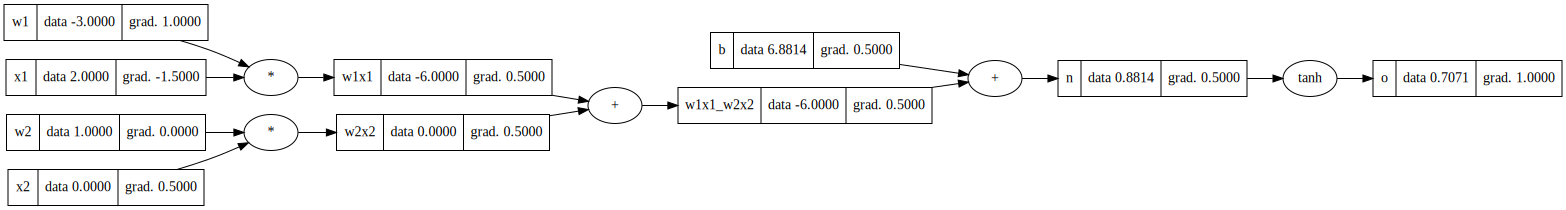

In [ ]:
draw_dot(o)

#PyTorch

In [ ]:
import torch

In [ ]:
# Double makes it so dtype goes from float32 to float64 (python regularly uses this)
# Because these are leaf nodes, pytorch assumes they do not gradients by default
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# .item() just take a single tensor and returns element; stripping out tensor
print(o.data.item())

# Pytorch has its own backward function and basically does what we did
o.backward()

print('----------')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
----------
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [ ]:
class Neuron:
  def __init__(self, num_inputs):
    # Create random weight and bias for every input for this neuron
    self.weight = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
    self.bias =  Value(random.uniform(-1, 1))

    # What to do when this is called as a function
  def __call__(self, x):
    # zip basically creates tuples of each wieght with each x
    # let x = [2.0, -3.0], then it would return (weight, 2.0), (weight, -3.0)
    # For some reason the sum function is broken
    sum = Value(0.0)
    for xi, wi in zip(self.weight, x):
     sum += (xi*wi + self.bias)

    #activation = sum((xi*wi for xi, wi in zip(self.weight, x)), self.bias)
    out = sum.tanh()
    return out

  # Pytorch also has this parameters function
  def parameters(self):
    # Self.weight is a list
    return self.weight + [self.bias]


class Layer:
  def __init__(self, num_inputs, num_outputs):
    self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    # Convenient for last layer
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [param for neuron in self.neurons for param in neuron.parameters()]
    # Also is just this:
    '''params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)'''


class MLP:
  def __init__(self, num_inputs, size_of_layers):
    sz = [num_inputs] + size_of_layers
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(size_of_layers))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [param for layer in self.layers for param in layer.parameters()]


In [ ]:
my_MLP = MLP(3, [4, 4, 1])
x = [2.0, 3.0, -1.0]
my_MLP(x)
print(my_MLP.parameters())

[Value(data = -0.603778086258077), Value(data = -0.7715176290091892), Value(data = 0.48700971538281057), Value(data = -0.8680567268863899), Value(data = 0.1579773649496028), Value(data = -0.022171695747209563), Value(data = -0.8381789875624799), Value(data = -0.6803565963816698), Value(data = -0.32070655277023197), Value(data = -0.127060807800214), Value(data = -0.4134120532967549), Value(data = 0.5190838147274237), Value(data = -0.6978879103899542), Value(data = 0.1869853681939173), Value(data = -0.537890460137459), Value(data = -0.10265350665738393), Value(data = 0.25041933264374006), Value(data = 0.5230524304469544), Value(data = 0.5985614043188625), Value(data = -0.2790471834840864), Value(data = -0.4919515215836585), Value(data = -0.9912429105137799), Value(data = -0.5575285190516166), Value(data = 0.7688186076497261), Value(data = -0.029548363803961752), Value(data = 0.8840146172114591), Value(data = -0.20265736836670478), Value(data = -0.016183992853292306), Value(data = 0.86373

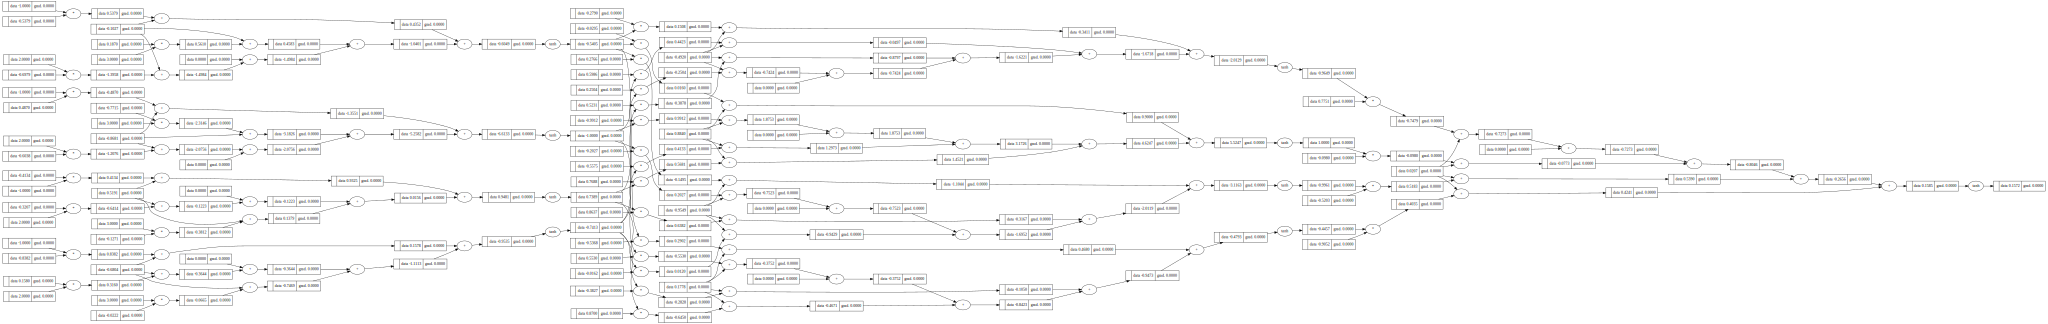

In [ ]:
draw_dot(my_MLP(x))

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(20):
  # Forward pass
  y_pred = [my_MLP(x) for x in xs]
  loss = [(yout-ygt)**2 for yout, ygt in zip(y_pred, ys)]
  loss_value = Value(0.0)
  print(y_pred)
  for x in loss:
    loss_value += x

  # Backward pass
  # Make it so the grads do not accumulate
  for p in my_MLP.parameters():
    p.grad = 0.0
  # Fill in the grad again
  loss_value.backward()

  # Gradient Descent
  for p in my_MLP.parameters():
    p.data += -0.05 * p.grad

print(loss_value)

[Value(data = 0.9458533262812641), Value(data = -0.953423466903814), Value(data = -0.93560781364195), Value(data = 0.9419082970344513)]
[Value(data = 0.9461155313219531), Value(data = -0.9536348044967303), Value(data = -0.9359287188345394), Value(data = 0.9421876625850214)]
[Value(data = 0.946374023370694), Value(data = -0.9538432502971281), Value(data = -0.9362450287255158), Value(data = 0.9424630986100163)]
[Value(data = 0.9466288886167739), Value(data = -0.9540488697985495), Value(data = -0.9365568507300012), Value(data = 0.9427346958134872)]
[Value(data = 0.9468802104862214), Value(data = -0.9542517264356305), Value(data = -0.9368642888018655), Value(data = 0.9430025420054994)]
[Value(data = 0.9471280697543396), Value(data = -0.9544518816665784), Value(data = -0.9371674435752494), Value(data = 0.9432667222194903)]
[Value(data = 0.9473725446527009), Value(data = -0.9546493950516429), Value(data = -0.9374664124990978), Value(data = 0.9435273188238738)]
[Value(data = 0.947613710970921

In [ ]:
draw_dot(loss_value)